<a href="https://colab.research.google.com/github/sergiosb99/SSJ_SupervisedLearning/blob/Novelty/Dengue_Upgrade_Hierarchy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  The Problem


We will use the data from the competition to predict the evolution of Dengue Disease in both Iquitos and San Juan. More information in [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

The objective of the exercise is to solve a regression problem and on the other hand to participate in a data competition.


# Setting Preliminares

Before starting any analysis we must ensure that the basic and general use libraries (numpy, pandas, etc.) are correctly imported. 

In [ ]:
# carga de datos
import pandas as pd
import io

# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

import plotly.express as px

#Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Hierarchical Clustering
from sklearn import neighbors
from scipy.cluster import hierarchy

# Clustering Execution
from sklearn import metrics
from random import randint
from sklearn.cluster import KMeans, DBSCAN

from sklearn import preprocessing


# Data Loading

First we load the data into the environment with the functionalities provided by Google Colab

# Preprocessing

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers and apply simple clustering to novetly ...

In [ ]:
def hirechical_clustering(df, datanorm, cut):
      dist = neighbors.DistanceMetric.get_metric('euclidean')
      matsim = dist.pairwise(datanorm)
      fig = px.imshow(matsim)
      #fig.show()
      avSim = np.average(matsim)
      print("%s\t%6.2f" % ('Distancia Media', avSim))

      method_name = "ward"      #@param [ "single", "complete", "average", "weighted","centroid", "median", "ward"]   
      # Building the Dendrogram

      clusters = hierarchy.linkage(matsim, method = method_name) 
      hierarchy.dendrogram(clusters, color_threshold=cut) # buscar corte
      plt.show()

      labels = hierarchy.fcluster(clusters, cut , criterion = 'distance')
      print ('Number of clusters %d' % (len(set(labels))))
      labels

      colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
      colors = np.hstack([colors] * 20)


      fig, ax = plt.subplots()

      for i in range(len(datanorm)):
          plt.text(datanorm[i][0], datanorm[i][1], 'x', color=colors[labels[i]])  

      plt.xlim(np.min(datanorm[:])-0.5, np.max(datanorm[:])+0.5)
      plt.ylim(np.min(datanorm[:])-0.5, np.max(datanorm[:])+0.5)

      ax.grid(True)
      fig.tight_layout()
      plt.show()

      # tratamos el cluster -1 como cluster de outliers
      n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
      print('Estimated number of clusters: %d' % n_clusters_)
      print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(datanorm, labels))

      
      #plotting orginal points with color related to label
      fig = px.scatter(x=datanorm[:,0], y= datanorm[:,1], color = labels)

      for i in range(0,len(datanorm)):
          fig.add_annotation(x = datanorm[i,0], y = datanorm[i,1], text = str(df.iloc[i,:].name))
      #fig.show()

      df['group_h'] = labels

      return df['group_h']

In [ ]:
# make function to preprocess data
def preprocess_data(data_path, cut, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path)
    
    # fill missing values
    # try instead using mean and median
    df.fillna(df.mean(), inplace=True)


    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path)
        #df = df.join(labels)
    

    df.drop("week_start_date", axis = 1, inplace = True)
    selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c']
    df = df[selected_features]

    scaler = StandardScaler()  #@param ["MinMaxScaler()", "StandardScaler()"] {type:"raw"}
    

    datanorm = scaler.fit_transform(df)

    df['group_h'] = hirechical_clustering(df, datanorm, cut)

    cluster_1_features = df[df.group_h == 1]
    cluster_2_features = df[df.group_h == 2]

    cluster_1_features = cluster_1_features.drop(['group_h'], axis=1)
    cluster_2_features = cluster_2_features.drop(['group_h'], axis=1)              

#sj_labels.head()
    if labels_path:
        lb = preprocessing.LabelBinarizer()
        labels['city'] = lb.fit_transform(labels['city'])
        labels['group_h'] = df['group_h']
        cluster_1_labels = labels[labels.group_h == 1]    
        cluster_2_labels = labels[labels.group_h == 2]

        cluster_1_labels = cluster_1_labels.total_cases
        cluster_2_labels = cluster_2_labels.total_cases
        return cluster_1_features, cluster_2_features, cluster_1_labels, cluster_2_labels
    return cluster_1_features, cluster_2_features

Distancia Media	  2.46


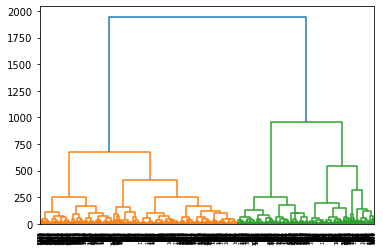

Number of clusters 2


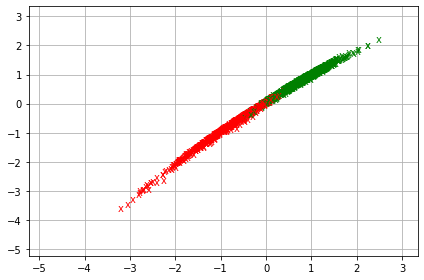

Estimated number of clusters: 2
Silhouette Coefficient: 0.484


In [ ]:
cluster_1_features, cluster_2_features, cluster_1_labels, cluster_2_labels = preprocess_data('dengue_features_train.csv',1000, labels_path="dengue_labels_train.csv")

Distancia Media	  2.49


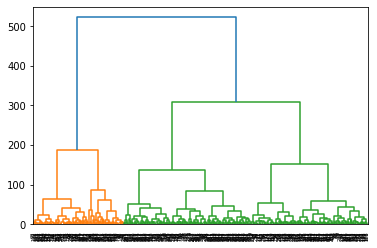

Number of clusters 2


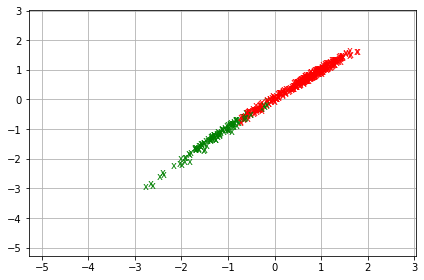

Estimated number of clusters: 2
Silhouette Coefficient: 0.458


In [ ]:
#load final test data
cluster_1_test_final, cluster_2_test_final = preprocess_data("dengue_features_test.csv",400)

In [ ]:
We will see the correlation matrix

You have to select features, they can be all, but that is usually not a good idea, so here we will leave some selected.

Now we are going to train the model with the training data

In [ ]:
#randomly separating data
# splitting data into training set and validation set

cluster_1_train, cluster_1_test, cluster_1_train_target, cluster_1_test_target = train_test_split(cluster_1_features, cluster_1_labels, test_size=0.3, random_state=41)

cluster_2_train, cluster_2_test, cluster_2_train_target, cluster_2_test_target = train_test_split(cluster_2_features, cluster_2_labels, test_size=0.3, random_state=41)

# Submission result

We generate the output file according to the Submission format

Once we have identified the best parameterization we will go on to make an execution of the model and we will graph its results.


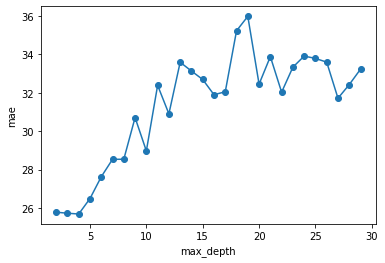

In [ ]:
# Compute the max 
mae = []
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
for i in range(2, 30):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(cluster_1_train,cluster_1_train_target)
    pred_values = regressor.predict(cluster_1_test)
    maev = mean_absolute_error(cluster_1_test_target,pred_values)
    mae.append(maev)
    
# Plot mae   
plt.plot(range(2,30), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

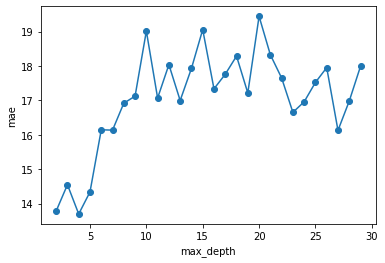

In [ ]:
# Compute the max 
mae = []
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
for i in range(2, 30):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(cluster_2_train,cluster_2_train_target)
    pred_values = regressor.predict(cluster_2_test)
    maev = mean_absolute_error(cluster_2_test_target,pred_values)
    mae.append(maev)
    
# Plot mae   
plt.plot(range(2,30), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

In [ ]:
def TreeRegressor(city_feat, city_labels, depth):
    '''
    this function builds a decision tree regressor model given a city
    '''        
    regressor = DecisionTreeRegressor(splitter='best', max_depth=depth, min_samples_split=2,
                                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None,
                                      max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, ccp_alpha=0.0)
    regressor.fit(city_feat,city_labels)
    return regressor

In [ ]:
cluster_1_model = TreeRegressor(cluster_1_train, cluster_1_train_target, )
cluster_2_model = TreeRegressor(cluster_2_train, cluster_2_train_target, 3)

1. We carry out the prediction on the test.

In [ ]:
from sklearn.metrics import mean_absolute_error
pred_c1 = cluster_1_model.predict(cluster_2_test)
score_c1 = mean_absolute_error(cluster_2_test_target,pred_c1)

pred_c2 = cluster_2_model.predict(cluster_1_test)
score_c2 = mean_absolute_error(cluster_1_test_target,pred_c2)
print("Error Measure cluster 1: ",score_c1, "\nError Measure cluster 2: ", score_c2)

Error Measure cluster 1:  13.858827452386231 
Error Measure cluster 2:  25.803465202635866


Finally we try to visualize how our prediction has turned out with reality.

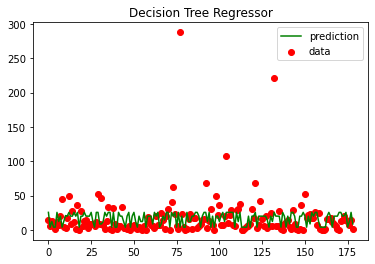

In [ ]:
#plt.subplot(2, 1, i + 1)
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(len(cluster_2_test_target)))
plt.scatter(xx, cluster_2_test_target, c='r', label='data')
plt.plot(xx, pred_c1, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("Decision Tree Regressor")

plt.show()

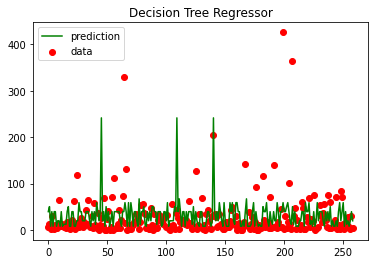

In [ ]:
#plt.subplot(2, 1, i + 1)
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(len(cluster_1_test_target)))
plt.scatter(xx, cluster_1_test_target, c='r', label='data')
plt.plot(xx, pred_c2, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("Decision Tree Regressor")

plt.show()

In [ ]:
# FEATURE RELEVANCIES (I don't know what it does)
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c') ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,reanalysis_specific_humidity_g_per_kg,0.179892
1,reanalysis_dew_point_temp_k,0.332790
2,station_avg_temp_c,0.305108
3,station_min_temp_c,0.182210


2. We round up the result. **We use dataset TEST!**

In [ ]:
final_sj_predictions = cluster_1_model.predict(cluster_1_test_final)
final_iq_predictions = cluster_2_model.predict(cluster_2_test_final)

In [ ]:
submission = np.concatenate([final_sj_predictions.astype(np.int64), final_iq_predictions.astype(np.int64)])

# round the result and cast to int
import numpy as np
y = np.rint(submission) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([ 25,  20,  20,  25,  20,  20,  25,  25,  25,  20,  20,  20,  20,
        20,  20,  20,  20,  20,  20,  12,  20,  25,  12,  25,  25,  20,
        12,  25,  25,  25,  12,  12,  12,  20,  20,  20,  20,  20,  25,
        25,  25,  20,  20,  25,  20,  20,  20,  20,  20,  25,  12,  12,
        12,  12,  25,  20,  12,  25,  25,  20,  20,  20,  20,  20,  20,
        12,  12,  20,  12,  20,  12,  25,  25,  20,  20,  25,  20,  20,
        20,  12,  12,  20,  12,  25,   3,   3,  12,   3,  25,   8,   3,
         3,   3,   3,   3,   3,   3,  25,   3,  25,  25,  25,  20,  12,
         3,   3,  25,   3,   3,   3,   3,   3,  12,   7,  19,  58,  58,
        58,  58,  39,  39,  39,  58,  39,  39,  39,  39,  39,  39,  39,
        67,  39,  39,  19,  50,  39,  19,  58,  58,  39,  58,  58,  19,
        19,  58,  19,  39,  58,  58,  39,  58,  39,  39,  39,  39,  39,
        39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,
        58,  19,  39,  39,  58,  58,  50,  19,  19,   7,  19,  5

3. We build the output file


In [ ]:
sj_test_final

In [ ]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])


submission.total_cases = np.concatenate([final_sj_predictions.astype(np.int64), final_iq_predictions.astype(np.int64)])
submission.to_csv("result.csv")

Upload new submission
Woohoo! We processed your submission!
Your score for this submission is:

35.4832 
Woo! I scored 35.4832 on 'DengAI: Predicting Disease Spread'!